# Deform a sphere into a cube

---


This notebook solves the problem of deforming a sphere into a cube using different methods.


Import the required modules.


In [1]:
import numpy as np
import pyvista as pv
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import numerical_geometry as ng

---

## 1 - Create source and target meshes


We can create a sphere (source) mesh and a cube (target) mesh using the `utils.sphere()` and `utils.cube()` functions respectively. Generating meshes of spheres and cubes is discussed in the `sphere.ipynb` and `cube.ipynb` notebooks respectively. We will also calculate vertex normals for the sphere mesh.


In [2]:
sphere_mesh = ng.sphere(num_polar_angles=100, num_azimuthal_angles=200)
cube_mesh = ng.cube(num_points_per_side=50)

normals = sphere_mesh.points / np.linalg.norm(sphere_mesh.points, axis=1, keepdims=True)
sphere_mesh.point_data["normals"] = normals

Plot the sphere (source) mesh and the cube (target) mesh.


In [3]:
pl = pv.Plotter(shape=(1, 2))

pl.subplot(0, 0)
pl.add_mesh(sphere_mesh, show_edges=True)
pl.add_text("Sphere (source)", font_size=12)

pl.subplot(0, 1)
pl.add_mesh(cube_mesh, show_edges=True)
pl.add_text("Cube (target)", font_size=12)

pl.show()

Widget(value='<iframe src="http://localhost:54566/index.html?ui=P_0x175bb4ad0_0&reconnect=auto" class="pyvista…

---

## 2 - Deform a sphere into a cube using ray tracing


The first step to solve this problem is to find where the vertex normals of the sphere intersect the faces of the cube. This is a ray tracing problem, and can be solved using PyVista's built in ray tracing functionality. The ray tracing logic is implemented in the `ng.get_intersection_points()` function, which uses PyVista's `ray_trace()` method to find where the sphere's vertex normals intersect the faces of the cube.


In [4]:
intersection_points, intersection_rays, intersection_cells = ng.get_intersection_points(
    sphere_mesh,
    cube_mesh,
)

deformation = intersection_points - sphere_mesh.points

print(sphere_mesh.points.shape)
print(intersection_points.shape)

(19602, 3)
(19602, 3)


To deform the sphere, we simply need to multiply the deformation field, $\vec{d}$, by a scalar, $t \in [0, 1]$, and evolve the position of each vertex according to this new deformation field. This is handled by the `utils.animate_deformation()` function.


In [5]:
ng.animate_deformation(
    source_mesh=sphere_mesh,
    target_mesh=cube_mesh,
    deformation=deformation,
)

Widget(value='<iframe src="http://localhost:53569/index.html?ui=P_0x176056c10_1&reconnect=auto" class="pyvista…

---

## 3 - Deform a sphere into a cube using a neural network


We will now try to solve the problem using a neural network. We will aim to learn a function $f: \mathbb{R}^3 \rightarrow \mathbb{R}^3$ that maps the points of the source mesh to the deformation field. One benefit of this approach is that we can learn the function on a low dimensional representation (i.e. sparse source and target meshes), and then apply the function to a dense source mesh.


Set the device to MPS if available (you will need to modify this block of code if you aren't using an Apple silicon device).


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


### 3.1 - Create the model


We can initialize a multilayer perceptron (MLP) and an optimizer using the `ng.new_network()` function.


In [5]:
model = ng.core.NeuralNetwork(parameters=128, layers=4).to(device)

### 3.2 - Loss function


In order to optimize the parameters, we need a loss function. To start with, the loss function will have two terms: a Chamfer distance term, and a term which penalizes large deformations. The Chamfer distance provides a measure of how close two point clouds are.


In [ ]:
lambda_chamfer = 1
lambda_deformation = 1e-6


def loss_function(source, target, deformation):
    """
    Loss function
    =============

    Computes the loss.
    """

    chamfer_distance = ng.get_chamfer_distance(source + deformation, target)
    average_deformation = ng.get_average_deformation(deformation)

    loss = (lambda_chamfer * chamfer_distance) + (
        lambda_deformation * average_deformation
    )
    return loss

### 3.3 - Training


We now have everything we need to train the model. The training is handled by the `train_model()` function.


[10/100]: loss = 0.050903
[20/100]: loss = 0.031390
[30/100]: loss = 0.025058
[40/100]: loss = 0.024460
[50/100]: loss = 0.024080
[60/100]: loss = 0.023934
[70/100]: loss = 0.023784
[80/100]: loss = 0.023482
[90/100]: loss = 0.023271
[100/100]: loss = 0.023160


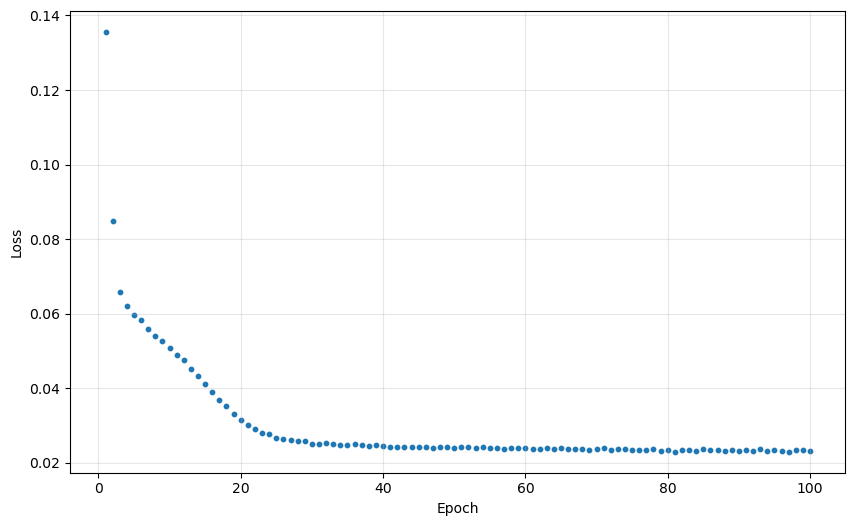

In [7]:
model.train_model(
    source_mesh=sphere_mesh,
    target_mesh=cube_mesh,
    device=device,
    loss_function=loss_function,
    optimizer_type="SGD",
    epochs=100,
    batch_size=512,
    target_batch_size=1000,
    learning_rate=1e-1,
)

### 3.4 - Testing


Now that we have trained the model, we can use it to calculate a deformation field.


In [8]:
deformation = model.get_deformation_field(sphere_mesh, device)

We can now apply the deformation field to the source.


In [9]:
ng.animate_deformation(
    source_mesh=sphere_mesh, target_mesh=cube_mesh, deformation=deformation
)

Widget(value='<iframe src="http://localhost:54566/index.html?ui=P_0x32453b9d0_1&reconnect=auto" class="pyvista…